# Project 3 - Behavioral Cloning
## Ajay Paidi

In [1]:
# Import necessary modules
from get_data import *
from sklearn.model_selection import train_test_split
import math
import numpy as np
import seaborn as sns
from model import *
from scipy.misc import imread
import cv2
# Visualizations will be shown in the notebook.
#plt.style.use('ggplot')
plt.style.use('seaborn-notebook')
%matplotlib inline
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


# Data acquisition

I acquired the training data by driving muliple laps around the training track (track 1) in the Udacity simulator.I used the keyboard inputs to drive the car and recorded data from all the cameras (left, right and center). There were quite a few discussions on the forums about using an analog input to drive the car (eg. Joystick, xbox controller etc.). I was able to train a reasonable model using the keyboard driven car. So thankfully I did not have to go buy an expensive controller.
Overall I performed the training over 4 different sessions to generate a total of 19738 data points. This corresponds to 59214 images (since each data point has 3 images - left cam, right cam and center cam).
I also decided to use the udacity provided data as my validation data.This data has about 8036 data points which correspond to 24108 images.

In [2]:
# Paths and filenames of the generated data
filename1 = 'train_data/driving_log1.csv'
filename2 = 'train_data/driving_log2.csv'
filename3 = 'train_data/driving_log3.csv'
filename4 = 'train_data/driving_log4.csv'
filenames_list = [filename1, filename2, filename3, filename4]
filepath = 'train_data/IMG/'
valid_filename = ['validation_data/data/driving_log.csv']
valid_filepath = 'validation_data/data/IMG/'

# Data visualization

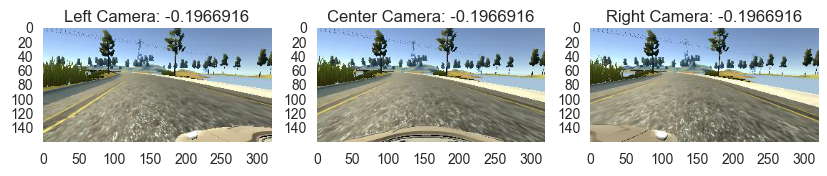

In [3]:
# Run this cell several times to get an idea of how the images look like
def display_random_image(filename, filepath):
    df = get_dataframe([filename], filepath)
    n_samples = len(df)
    index = np.random.randint(n_samples)
    row_data = df.iloc[index]
    left_filename = row_data['left'].strip()
    center_filename = row_data['center'].strip()
    right_filename = row_data['right'].strip()
    st_angle = row_data['steering']
    im_left = imread(left_filename)
    im_center = imread(center_filename)
    im_right = imread(right_filename)
    plt.figure(figsize = (10,20))
    plt.tight_layout
    with plt.style.context('seaborn-notebook'):
        ax = plt.subplot(1,3,1)
        ax.grid(False)
        plt.imshow(im_left)
        plt.title("Left Camera: " + str(st_angle))
        ax = plt.subplot(1,3,2)
        ax.grid(False)
        plt.imshow(im_center)
        plt.title("Center Camera: " + str(st_angle))
        ax = plt.subplot(1,3,3)
        ax.grid(False)
        plt.imshow(im_right)
        plt.title("Right Camera: " + str(st_angle))
display_random_image(filename4, filepath)
    
    
    

Observations: 
1. There is a lot of extraneous information in the images. For example the sky, the trees etc. would not really contribute much to the learning (in fact it could quite possibly train the model to overfit easily). Hence cropping the images could be useful.
2. Depending on the terrain, the brightness of the image keeps varying. This is the bane of using RGB images. It is very hard to compensate for varying brightness. Switching to an alternate color space (eg. HSV) could prove useful.

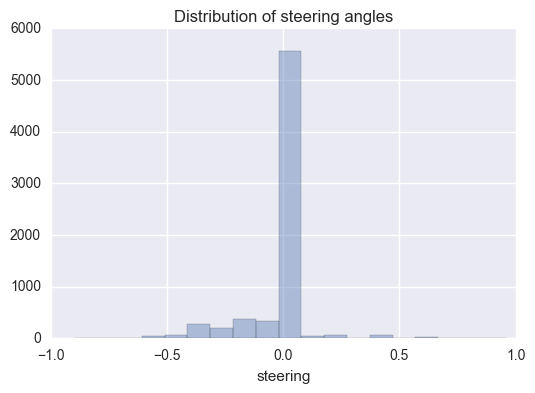

In [4]:
# plot the distribution of steering angles
def display_steering_angle_distribution(filename, filepath): 
    df = get_dataframe([filename], filepath)
    sns.distplot(df['steering'], kde=False, bins=20)
    plt.title("Distribution of steering angles")
    plt.show()
display_steering_angle_distribution(filename4, filepath)

Observations: The dataset is highly unbalanced in two specific ways
1. High proportion of zero steering angles: This closely reflects the real world driving mechanics. Most of the time a driver has the steering wheel at the zero angle position unless or until a turn or adjustment has to be made. One possible way to account for this is to 'undersample' the zero steering angle data and 'oversample' the non-zero steering angle data. But one has to make sure there is enough data before doing this (otherwise one can potentially lose valuable information).
2. Left right imbalance: There is a high proportion of negative steering angle data compared to positive steering angle data. This is due to the nature of the training track where most of turns involved turning left.This imbalance can only be addressed through a smart data augmentation strategy.

# Data pre-processing and augmentation

In order to address the zero steering angle imbalance, the prepare_data routine in get_data.py was written to do the following
1. Undersampling: The excess zero steering angles issue was addressed by throwing out approximately 1/3rd of the data points with a steering angle value of zero. This is done by the routine remove_zero_ind in the get_data.py file.
2. Oversampling: The low number of non-zero steering angle data points was addressed by duplicating those data points. This was done in two steps. Data points with steering angles between 0.03 and 0.5 (and -0.03 and -0.5) were duplicated twice. Data points with steering angles greater than 0.5 (and less than -0.5) were duplicated 4 times. This is done by the routine boost_samples in the get_data.py file.


Based on the observations from the data visualization activity, the following pre-processing/augmentation was performed on the images. Please note that some of these augmentation strategies were motivated by this excellent blog post by Vivek Yadav https://chatbotslife.com/using-augmentation-to-mimic-human-driving-496b569760a9#.8r6951ym7
1. The top 1/4th and bottom 1/5th of the pixels were cropped in each image (to remove extraneous information).
2. The images were converted to HSV color space (to make them independent of the brightness component).
3. To address the left-right imbalance, the images were randomly flipped. Correspondingly the steering angle sign was inverted.
4. An angle shift of 0.23 was added to the steering angle corresponding to the left camera image and subtracted from sterring angle corresponding to the right camera image. This had the effect of converting the left/right camera images to the corresponding center camera images (since prediction will be done only on center camera images). Please refer to the document Augmentation_Calculation.pdf on how I arrived at the angle shift value of 0.23.
5. The image pixels were randomly translated left right (translation values randomly chosen between -50 to 50 pixels). For every pixel shift a value of 0.005 was added (for right shift) or subtracted (for left shift). Please refer to the document Augmentation_Calculation.pdf on how I arrived at the translation adjustment value of 0.005. The idea behind this strategy is to train the model to look at some steep curves and more non-zero steering angle scenarios (and simulate recovery scenarios as well).
6. Resize final image to 64 x 64. This was based on trial and error. A smaller image helped train my network faster without any significant difference in how well the car behaved during testing.


The above activities were performed in a routine called 'apply_random_augmentation' inside the augment_data.py file. This routine was called by a generator function that was then fed to the keras model during training. The idea here is that these activities could happen 'on the fly' during training, thereby saving significant runtime memory and hard disk storage.

# Data visualization after pre-processing / augmentation

In [5]:
# Read the csv files as pandas dataframes and do some pre-processing
df_train = get_dataframe(filenames_list, filepath)
df_train = prepare_data(df_train)
df_valid = get_dataframe(valid_filename, valid_filepath)
num_train = df_train.shape[0] * 3 #21000
num_valid = df_valid.shape[0] * 3 #3500
print("num train images", num_train)
print("num valid images", num_valid)

Num rows is  19738
Num rows after zero ind removal  18830
num train images 56490
num valid images 24108


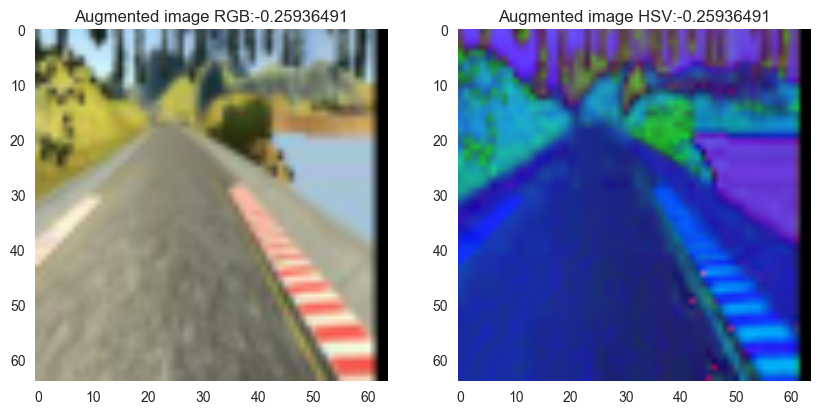

In [11]:
def display_random_aug_image(df, filepath):
    n_samples = len(df)
    index = np.random.randint(n_samples)
    row_data = df.iloc[index]
    im_hsv, st_angle = apply_random_augmentation(row_data)
    im_rgb = cv2.cvtColor(im_hsv, cv2.COLOR_HSV2RGB)
    plt.figure(figsize = (10,20))
    plt.tight_layout
    ax = plt.subplot(1,2,1)
    ax.grid(False)
    plt.imshow(im_rgb)
    plt.title("Augmented image RGB:" + str(st_angle))
    ax = plt.subplot(1,2,2)
    ax.grid(False)
    plt.imshow(im_hsv)
    plt.title("Augmented image HSV:" + str(st_angle))
    
#df_vis = get_dataframe([filename4], filepath)
display_random_aug_image(df_train, filepath)

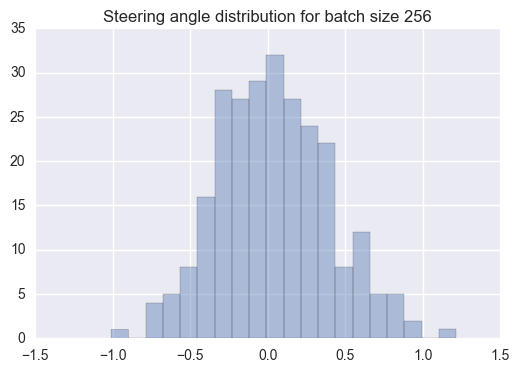

In [7]:
# Display steering angle distribution for a batch size that gets fed to keras generator
def display_aug_steering_angle_distribution(df, batch_size):
    X, y = next(aug_data_generator(df, batch_size))
    sns.distplot(y, kde=False, bins=20)
    plt.title("Steering angle distribution for batch size " + str(batch_size))
    plt.show()
display_aug_steering_angle_distribution(df_train, 256)
    

The above plot represents the steering angle distribution for a particular batch size that gets fed to the generator function that is called upon while training the keras model. The dataset looks reasonably balanced now and approximates a Gaussian distribution.

# Model training

I chose to treat this problem as a regression problem where the model outputs continuous steering angle values. Accordingly an MSE (Mean Squared Error) function was chosen as the loss function. An Adam optimizer was used to train the model. An initial learning rate of 1e-4 was chosen. These implementation details can be seen in the model.py file.  

In [8]:
# Get the model
model = get_nvidia_model()
# Train the model
batch_size = 256
train_samples_per_epoch = 25600
validation_samples_per_epoch = num_valid
nb_epoch=12

history = train_model(model, df_train, df_valid, batch_size, nb_epoch, train_samples_per_epoch, validation_samples_per_epoch)

Epoch 1/12
25600/25600 [==============================] - 326s - loss: 0.1475 - val_loss: 0.0444
Epoch 2/12
25600/25600 [==============================] - 301s - loss: 0.1177 - val_loss: 0.0393
Epoch 3/12
25600/25600 [==============================] - 300s - loss: 0.1092 - val_loss: 0.0372
Epoch 4/12
25600/25600 [==============================] - 300s - loss: 0.1015 - val_loss: 0.0353
Epoch 5/12
25600/25600 [==============================] - 300s - loss: 0.0951 - val_loss: 0.0344
Epoch 6/12
25600/25600 [==============================] - 300s - loss: 0.0894 - val_loss: 0.0329
Epoch 7/12
25600/25600 [==============================] - 301s - loss: 0.0865 - val_loss: 0.0327
Epoch 8/12
25600/25600 [==============================] - 303s - loss: 0.0818 - val_loss: 0.0336
Epoch 9/12
25600/25600 [==============================] - 300s - loss: 0.0796 - val_loss: 0.0348
Epoch 10/12
25600/25600 [==============================] - 303s - loss: 0.0789 - val_loss: 0.0352
Epoch 11/12
25600/25600 [====

Each of the 12 weights were evaluated on both the tracks. Although epoch 7 has the lowest validation loss, the weights corresponding to epoch 9 (model.08.h5) seemed to provide better performance on track 1.